In [1]:
import os
import functools
from warnings import simplefilter

In [2]:
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

#### Configure path parameters and read data files

The `RANDOM_SEED`, `NUM_EPOCHS`, `TRAIN_FRAC`, and `VAL_FRAC` are the same for all models during evaluaiton

In [3]:
MIDS_USER = os.getenv("MIDS_USER", None)  # this can be replaced, with e.g. `m25...`

if MIDS_USER is None:
  ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), *['..'] * 1)) 
else:
  ROOT_DIR = f"/home/mids/{MIDS_USER}/Capstone"

IMAGES_DIR = os.path.join(ROOT_DIR, "data", "datasets", "aircraft", "images")
if not os.path.exists(IMAGES_DIR):
  ROOT_DIR = os.path.join(ROOT_DIR, "lc-14")
  IMAGES_DIR = os.path.join(ROOT_DIR, "data", "datasets", "aircraft", "images")

RADOM_SEED = 2020
TRAIN_FRAC = 0.8
VAL_FRAC = 0.1

NUM_EPOCHS = 10   # This can be adjusted as needed 

In [4]:
image_dir = IMAGES_DIR
labels_fp = os.path.join(ROOT_DIR, "data", "datasets", "aircraft", "annotations.csv")

#### Load utility functions

In [5]:
os.chdir(ROOT_DIR)

In [20]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from src.utilities.data.aircraft_dataloader import get_dataloader

#### Load models and transformations

In [7]:
from src.models.baseline.cnn import BaselineCNN
from src.models.alpha.model import AlphaModel
# from src.models.beta.model import BetaModel
# from src.models.final.model import FinalModel

from src.transformations.baseline.transformations import baseline_transformations
from src.transformations.alpha.transformations import alpha_transformations
# from src.transformations.beta.transformations import beta_transformations
# from src.transformations.final.transformations import final_transformations

#### Define evaluation configuration

In [8]:
# We will use `functools.partial` to create a partial function that we can use to create instances of our models
# These will be instantiated in the training loop
default_criterion = functools.partial(nn.MSELoss)

baseline_model = functools.partial(BaselineCNN)
baseline_model_optimizer = functools.partial(
  torch.optim.Adam, 
  lr=0.01,
)
alpha_model = functools.partial(AlphaModel)
alpha_model_optimizer = functools.partial(
  torch.optim.Adam, 
  lr=1e-5,
)
alpha_model_criterion = functools.partial(nn.SmoothL1Loss, beta=1.0)
# beta_model = functools.partial(BetaModel)
# beta_model_optimizer = functools.partial(
#   torch.optim.Adam, 
#   lr=0.01,
# )
# final_model = functools.partial(FinalModel)
# final_model_optimizer = functools.partial(
#   torch.optim.Adam, 
#   lr=0.01,
# )

In [9]:
model_configurations = {
  "Baseline CNN": {
    "model_callable": baseline_model,
    "optimizer_callable": baseline_model_optimizer,
    "criterion_callable": default_criterion,
    "transformations": baseline_transformations,
    "dataloader_kwargs": {
      "batch_size": 4,
      "shuffle": True,
    },
  },
  "Alpha Model": {
    "model_callable": alpha_model,
    "optimizer_callable": alpha_model_optimizer,
    "criterion_callable": alpha_model_criterion,
    "transformations": alpha_transformations,
    "dataloader_kwargs": {
      "batch_size": 4,
      "shuffle": True,
    },
  },
  # "Beta Model": {
  #   "model_callable": beta_model,
  #   "optimizer_callable": beta_model_optimizer,
  #   "criterion_callable": default_criterion,
  #   "transformations": beta_transformations,
  #   "dataloader_kwargs": {
  #     "batch_size": 4,
  #     "shuffle": True,
  #   },
  # },
  # "Final Model": {
  #   "model_callable": final_model,
  #   "optimizer_callable": final_model_optimizer,
  #   "criterion_callable": default_criterion,
  #   "transformations": final_transformations,
  #   "dataloader_kwargs": {
  #     "batch_size": 4,
  #     "shuffle": True,
  #   },
  # },
}

### Train the models

In [10]:
for model_name, model_config in model_configurations.items():

  model_config["model"] = model_config["model_callable"]()
  model_config["optimizer"] = model_config["optimizer_callable"](params=model_config["model"].parameters())
  model_config["criterion"] = model_config["criterion_callable"]()
  model_config["model"] .train()

  # Training loop
  for epoch in range(NUM_EPOCHS):

    dataloader = get_dataloader(
      image_dir=image_dir,
      labels_fp=labels_fp,
      transformations=model_config["transformations"],
      mode='train',
      train_frac=TRAIN_FRAC,
      val_frac=VAL_FRAC,
      seed=RADOM_SEED + epoch,
      batch_size=model_config["dataloader_kwargs"]["batch_size"],
      shuffle=model_config["dataloader_kwargs"]["shuffle"],
      num_workers=1,
    )

    for i, (images, targets) in enumerate(dataloader):

      model_config["optimizer"].zero_grad()
      outputs = model_config["model"](images)
      loss = model_config["criterion"](outputs.squeeze(), targets)  # Ensure outputs are squeezed to match counts shape
      loss.backward()
      model_config["optimizer"].step()

    print(f"Model {model_name} epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}")


Model Baseline CNN epoch [1/10], Loss: 864.2848
Model Baseline CNN epoch [2/10], Loss: 832.1292
Model Baseline CNN epoch [3/10], Loss: 1428.3044
Model Baseline CNN epoch [4/10], Loss: 99.1084
Model Baseline CNN epoch [5/10], Loss: 105.5626
Model Baseline CNN epoch [6/10], Loss: 133.8037
Model Baseline CNN epoch [7/10], Loss: 275.3687
Model Baseline CNN epoch [8/10], Loss: 507.7363
Model Baseline CNN epoch [9/10], Loss: 82.2021
Model Baseline CNN epoch [10/10], Loss: 542.9631
Model Alpha Model epoch [1/10], Loss: 23.1099
Model Alpha Model epoch [2/10], Loss: 23.0219
Model Alpha Model epoch [3/10], Loss: 4.6880
Model Alpha Model epoch [4/10], Loss: 11.8102
Model Alpha Model epoch [5/10], Loss: 4.6776
Model Alpha Model epoch [6/10], Loss: 11.5360
Model Alpha Model epoch [7/10], Loss: 13.2365
Model Alpha Model epoch [8/10], Loss: 32.1365
Model Alpha Model epoch [9/10], Loss: 0.5944
Model Alpha Model epoch [10/10], Loss: 5.5978


### Evaluate the models

In [11]:
model_losses = {
  model_name: [] for model_name in model_configurations.keys()
}
model_predictions = {
  model_name: [] for model_name in model_configurations.keys()
}


In [12]:
for model_name, model_config in model_configurations.items():
  
  val_dataloader = get_dataloader(
    image_dir,
    labels_fp,
    transformations=model_config["transformations"],
    mode='val',
    train_frac=TRAIN_FRAC,
    val_frac=VAL_FRAC,
    seed=RADOM_SEED,
    batch_size=1,
    shuffle=True,
    num_workers=1,
  )
  true_labels = []

  model_config["model"].eval()

  for i, (val_images, targets) in enumerate(val_dataloader):
    predicted_counts = model_config["model"](val_images)
    # We validate based on the mean absolute error
    model_losses[model_name].append(torch.abs(predicted_counts - targets).item())
    model_predictions[model_name].append(predicted_counts.item())
    true_labels.append(targets.item())
    print(f"{model_name} - val image {i+1}, predicted count: {predicted_counts.item():.4f}, true count: {targets.item():.4f}")


Baseline CNN - val image 1, predicted count: 31.2943, true count: 39.0000
Baseline CNN - val image 2, predicted count: 31.2943, true count: 31.0000
Baseline CNN - val image 3, predicted count: 31.2943, true count: 19.0000
Baseline CNN - val image 4, predicted count: 31.2943, true count: 26.0000
Baseline CNN - val image 5, predicted count: 31.2943, true count: 52.0000
Baseline CNN - val image 6, predicted count: 31.2943, true count: 27.0000
Baseline CNN - val image 7, predicted count: 31.2943, true count: 24.0000
Baseline CNN - val image 8, predicted count: 31.2943, true count: 30.0000
Baseline CNN - val image 9, predicted count: 31.2943, true count: 49.0000
Baseline CNN - val image 10, predicted count: 31.2943, true count: 15.0000
Alpha Model - val image 1, predicted count: 29.7897, true count: 27.0000
Alpha Model - val image 2, predicted count: 33.2560, true count: 39.0000
Alpha Model - val image 3, predicted count: 27.5553, true count: 52.0000
Alpha Model - val image 4, predicted cou

### Compare the models

In [13]:
for model_name, model_losses in model_losses.items():
  print(f"Model {model_name} MAE: {sum(model_losses) / len(model_losses):.4f}")


Model Baseline CNN MAE: 9.3177
Model Alpha Model MAE: 9.6233


In [14]:
model_predictions

{'Baseline CNN': [31.294265747070312,
  31.294265747070312,
  31.294265747070312,
  31.294265747070312,
  31.294265747070312,
  31.294265747070312,
  31.294265747070312,
  31.294265747070312,
  31.294265747070312,
  31.294265747070312],
 'Alpha Model': [29.789697647094727,
  33.2559700012207,
  27.555313110351562,
  30.331716537475586,
  27.823352813720703,
  27.648530960083008,
  27.050718307495117,
  28.329893112182617,
  29.71107292175293,
  23.892059326171875]}

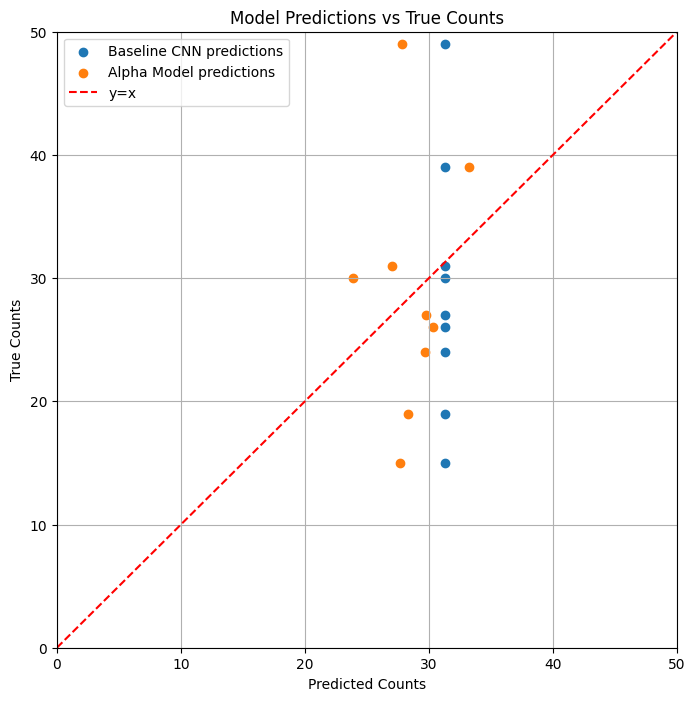

In [15]:
plt.figure(figsize=(8, 8))
for model_name, model_prediction in model_predictions.items():
  plt.scatter(model_prediction, true_labels, label=f"{model_name} predictions")

# Set the x and y axis labels and title
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.axline((0, 0), slope=1, color='red', linestyle='--', label='y=x')
plt.grid()
plt.xlabel("Predicted Counts")
plt.ylabel("True Counts")
plt.title("Model Predictions vs True Counts")
plt.legend()
plt.show()


### Use the models operationally against new data

This section uses new data (of a similar form, aerial images of aircraft and airports) to assess the model performance in a real-world scenario.

In [16]:
boneyard_aircraft_dir = "/home/cjellen/projects/github/lc-14/data/processed/boneyard/boneyard-aircraft"
boneyard_no_aircraft_dir = "/home/cjellen/projects/github/lc-14/data/processed/boneyard/boneyard-no-aircraft"

In [17]:
model_boneyard_predictions = {
  model_name: [] for model_name in model_configurations.keys()
}
model_boneyard_no_aircraft_predictions = {
  model_name: [] for model_name in model_configurations.keys()
}

In [ ]:
for model_name, model_config in model_configurations.items():
  
  # Boneyard with aircraft
  aircraft_dataloader = get_dataloader(
    boneyard_aircraft_dir,
    None,  # No labels for this dataset
    transformations=model_config["transformations"],
    mode='val',
    train_frac=0,
    val_frac=0.9,
    seed=RADOM_SEED,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    extension=".png",
  )

  model_config["model"].eval()

  for i, (val_images, targets) in enumerate(aircraft_dataloader):
    predicted_counts = model_config["model"](val_images)
    
    model_boneyard_predictions[model_name].append(predicted_counts.item())
    print(f"{model_name} - val image which includes aircraft {i+1}, predicted count: {predicted_counts.item():.4f}")


  # Boneyard without aircraft
  no_aircraft_dataloader = get_dataloader(
    boneyard_no_aircraft_dir,
    None,  # No labels for this dataset
    transformations=model_config["transformations"],
    mode='val',
    train_frac=0,
    val_frac=0.9,
    seed=RADOM_SEED,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    extension=".png",
  )

  model_config["model"].eval()

  for i, (val_images, targets) in enumerate(no_aircraft_dataloader):
    predicted_counts = model_config["model"](val_images)
    
    model_boneyard_no_aircraft_predictions[model_name].append(predicted_counts.item())
    print(f"{model_name} - val image which does not include aircraft {i+1}, predicted count: {predicted_counts.item():.4f}")


Baseline CNN - val image 1, predicted count: 31.2943
Baseline CNN - val image 2, predicted count: 31.2943
Baseline CNN - val image 3, predicted count: 31.2943
Baseline CNN - val image 4, predicted count: 31.2943
Baseline CNN - val image 5, predicted count: 31.2943
Baseline CNN - val image 6, predicted count: 31.2943
Baseline CNN - val image 7, predicted count: 31.2943
Baseline CNN - val image 8, predicted count: 31.2943
Baseline CNN - val image 9, predicted count: 31.2943
Baseline CNN - val image 10, predicted count: 31.2943
Baseline CNN - val image 11, predicted count: 31.2943
Baseline CNN - val image 12, predicted count: 31.2943
Baseline CNN - val image 13, predicted count: 31.2943
Baseline CNN - val image 14, predicted count: 31.2943
Baseline CNN - val image 15, predicted count: 31.2943
Baseline CNN - val image 16, predicted count: 31.2943
Baseline CNN - val image 17, predicted count: 31.2943
Baseline CNN - val image 18, predicted count: 31.2943
Baseline CNN - val image 19, predicte